## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5,0.3,0.1]
redice_lr_patient = [3,5,7]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1) 
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.3097 - accuracy: 0.5425 - val_loss: 1.4877 - val_accuracy: 0.4745
Epoch 12/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.2876 - accuracy: 0.5510 - val_loss: 1.4781 - val_accuracy: 0.4760
Epoch 13/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.2631 - accuracy: 0.5597 - val_loss: 1.4646 - val_accuracy: 0.4857
Epoch 14/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.2407 - accuracy: 0.5692 - val_loss: 1.4606 - val_accuracy: 0.4890
Epoch 15/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2199 - accuracy: 0.5755 - val_loss: 1.4573 - val_accuracy: 0.4861
Epoch 16/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.2013 - accuracy: 0.5828 - val_loss: 1.4483 - val_accuracy: 0.4880
Epoch 17/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.1811 - accuracy: 0.5911 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 71us/step - loss: 2.2196 - accuracy: 0.2666 - val_loss: 2.1847 - val_accuracy: 0.1926
Epoch 2/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.7571 - accuracy: 0.3857 - val_loss: 2.0301 - val_accuracy: 0.2689
Epoch 3/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.6337 - accuracy: 0.4238 - val_loss: 1.8629 - val_accuracy: 0.3382
Epoch 4/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.5565 - accuracy: 0.4511 - val_loss: 1.7323 - val_accuracy: 0.4008
Epoch 5/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.5019 - accuracy: 0.4714 - val_loss: 1.6550 - val_accuracy: 0.4152
Epoch 6/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.4603 - accuracy: 0.4866 - val_loss: 1.5836 - val_accuracy: 0.4461
Epoch 7/25
50000/50000 [==============================] - 3s 57us/st

50000/50000 [==============================] - 4s 72us/step - loss: 1.3959 - accuracy: 0.5145 - val_loss: 1.5497 - val_accuracy: 0.4568
Epoch 21/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.3863 - accuracy: 0.5183 - val_loss: 1.5469 - val_accuracy: 0.4560
Epoch 22/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.3742 - accuracy: 0.5215 - val_loss: 1.5390 - val_accuracy: 0.4609
Epoch 23/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.3637 - accuracy: 0.5254 - val_loss: 1.5354 - val_accuracy: 0.4593
Epoch 24/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.3532 - accuracy: 0.5290 - val_loss: 1.5329 - val_accuracy: 0.4648
Epoch 25/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.3428 - accuracy: 0.5320 - val_loss: 1.5280 - val_accuracy: 0.4666
Numbers of exp: 5, reduce_factor: 0.30, reduce_patient: 7
Model: "model_6"
_________________________________________________

Epoch 5/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.7108 - accuracy: 0.4026 - val_loss: 1.8054 - val_accuracy: 0.3679
Epoch 6/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.6667 - accuracy: 0.4176 - val_loss: 1.7417 - val_accuracy: 0.3861
Epoch 7/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.6304 - accuracy: 0.4307 - val_loss: 1.7012 - val_accuracy: 0.4040
Epoch 8/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.5995 - accuracy: 0.4411 - val_loss: 1.6690 - val_accuracy: 0.4139
Epoch 9/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.5719 - accuracy: 0.4519 - val_loss: 1.6512 - val_accuracy: 0.4204
Epoch 10/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.5492 - accuracy: 0.4582 - val_loss: 1.6331 - val_accuracy: 0.4268
Epoch 11/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.5276 - accuracy: 0.4663 - val_loss:

50000/50000 [==============================] - 3s 63us/step - loss: 1.3329 - accuracy: 0.5358 - val_loss: 1.5390 - val_accuracy: 0.4577
Numbers of exp: 8, reduce_factor: 0.10, reduce_patient: 7
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
_______________________________________________________________

50000/50000 [==============================] - 4s 72us/step - loss: 0.9538 - accuracy: 0.6695 - val_loss: 1.4871 - val_accuracy: 0.4783
Epoch 10/25
50000/50000 [==============================] - 4s 73us/step - loss: 0.9172 - accuracy: 0.6830 - val_loss: 1.5035 - val_accuracy: 0.4914
Epoch 11/25
50000/50000 [==============================] - 3s 62us/step - loss: 0.8848 - accuracy: 0.6938 - val_loss: 1.5187 - val_accuracy: 0.4762
Epoch 12/25
50000/50000 [==============================] - 4s 81us/step - loss: 0.8467 - accuracy: 0.7091 - val_loss: 1.4257 - val_accuracy: 0.5064
Epoch 13/25
50000/50000 [==============================] - 4s 76us/step - loss: 0.8201 - accuracy: 0.7180 - val_loss: 1.5455 - val_accuracy: 0.4802
Epoch 14/25
50000/50000 [==============================] - 3s 61us/step - loss: 0.7838 - accuracy: 0.7327 - val_loss: 1.6039 - val_accuracy: 0.4661
Epoch 15/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.7525 - accuracy: 0.7420 - val_loss: 1.5684

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 74us/step - loss: 2.0186 - accuracy: 0.3174 - val_loss: 2.1056 - val_accuracy: 0.2154
Epoch 2/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.6390 - accuracy: 0.4232 - val_loss: 1.9364 - val_accuracy: 0.3382
Epoch 3/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.5401 - accuracy: 0.4601 - val_loss: 1.7776 - val_accuracy: 0.4122
Epoch 4/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.4798 - accuracy: 0.4814 - val_loss: 1.6635 - val_accuracy: 0.4365
Epoch 5/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.4319 - accuracy: 0.4989 - val_loss: 1.5887 - val_accuracy: 0.4490
Epoch 6/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.3937 - accuracy: 0.5140 - val_loss: 1.5495 - val_accuracy: 0.4588
Epoch 7/25
50000/50000 [==============================] - 3s 59us/st

Epoch 21/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.0957 - accuracy: 0.6272 - val_loss: 1.4298 - val_accuracy: 0.5003

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
Epoch 22/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.0741 - accuracy: 0.6381 - val_loss: 1.4120 - val_accuracy: 0.5074
Epoch 23/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.0678 - accuracy: 0.6401 - val_loss: 1.4170 - val_accuracy: 0.5034
Epoch 24/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.0641 - accuracy: 0.6407 - val_loss: 1.4133 - val_accuracy: 0.5069
Epoch 25/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.0600 - accuracy: 0.6431 - val_loss: 1.4129 - val_accuracy: 0.5056

Epoch 00025: ReduceLROnPlateau reducing learning rate to 2.812500133586582e-06.
Numbers of exp: 13, reduce_factor: 0.30, reduce_patient: 5
Model: "model_14"
_____________________

Epoch 5/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.9766 - accuracy: 0.3231 - val_loss: 1.9539 - val_accuracy: 0.3091
Epoch 6/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.9380 - accuracy: 0.3356 - val_loss: 1.9182 - val_accuracy: 0.3200
Epoch 7/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.9072 - accuracy: 0.3447 - val_loss: 1.8954 - val_accuracy: 0.3320
Epoch 8/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.8801 - accuracy: 0.3536 - val_loss: 1.8777 - val_accuracy: 0.3374
Epoch 9/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.8578 - accuracy: 0.3593 - val_loss: 1.8663 - val_accuracy: 0.3468
Epoch 10/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.8368 - accuracy: 0.3648 - val_loss: 1.8596 - val_accuracy: 0.3514
Epoch 11/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.8191 - accuracy: 0.3705 - val_loss:

50000/50000 [==============================] - 4s 77us/step - loss: 1.6796 - accuracy: 0.4186 - val_loss: 1.7673 - val_accuracy: 0.3913
Numbers of exp: 16, reduce_factor: 0.10, reduce_patient: 5
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_49 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_50 (Batc (None, 256)               1024      
_____________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.8327 - accuracy: 0.3705 - val_loss: 1.8644 - val_accuracy: 0.3524
Epoch 11/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.8165 - accuracy: 0.3750 - val_loss: 1.8574 - val_accuracy: 0.3568
Epoch 12/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.8007 - accuracy: 0.3805 - val_loss: 1.8499 - val_accuracy: 0.3601
Epoch 13/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.7848 - accuracy: 0.3848 - val_loss: 1.8428 - val_accuracy: 0.3628
Epoch 14/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.7722 - accuracy: 0.3889 - val_loss: 1.8363 - val_accuracy: 0.3662
Epoch 15/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.7599 - accuracy: 0.3918 - val_loss: 1.8304 - val_accuracy: 0.3680
Epoch 16/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.7479 - accuracy: 0.3966 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 69us/step - loss: 2.1166 - accuracy: 0.2878 - val_loss: 2.1611 - val_accuracy: 0.2304
Epoch 2/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.7714 - accuracy: 0.3852 - val_loss: 2.0558 - val_accuracy: 0.2756
Epoch 3/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.6452 - accuracy: 0.4244 - val_loss: 1.9151 - val_accuracy: 0.3453
Epoch 4/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.5670 - accuracy: 0.4505 - val_loss: 1.7615 - val_accuracy: 0.3903
Epoch 5/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.5039 - accuracy: 0.4728 - val_loss: 1.6592 - val_accuracy: 0.4171
Epoch 6/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.4587 - accuracy: 0.4912 - val_loss: 1.6231 - val_accuracy: 0.4258
Epoch 7/25
50000/50000 [==============================] - 3s 58us/st

50000/50000 [==============================] - 3s 58us/step - loss: 1.2565 - accuracy: 0.5639 - val_loss: 1.4980 - val_accuracy: 0.4708
Epoch 21/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.2418 - accuracy: 0.5693 - val_loss: 1.4964 - val_accuracy: 0.4714
Epoch 22/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.2284 - accuracy: 0.5764 - val_loss: 1.4999 - val_accuracy: 0.4724
Epoch 23/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.2150 - accuracy: 0.5805 - val_loss: 1.4931 - val_accuracy: 0.4785
Epoch 24/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.2011 - accuracy: 0.5848 - val_loss: 1.4889 - val_accuracy: 0.4725
Epoch 25/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.1874 - accuracy: 0.5910 - val_loss: 1.4894 - val_accuracy: 0.4763
Numbers of exp: 21, reduce_factor: 0.30, reduce_patient: 3
Model: "model_22"
_______________________________________________

Epoch 5/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.6375 - accuracy: 0.4306 - val_loss: 1.7642 - val_accuracy: 0.3671
Epoch 6/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.5880 - accuracy: 0.4483 - val_loss: 1.6869 - val_accuracy: 0.4001
Epoch 7/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.5454 - accuracy: 0.4629 - val_loss: 1.6380 - val_accuracy: 0.4227
Epoch 8/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.5112 - accuracy: 0.4747 - val_loss: 1.6225 - val_accuracy: 0.4286
Epoch 9/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.4790 - accuracy: 0.4858 - val_loss: 1.5930 - val_accuracy: 0.4388
Epoch 10/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.4502 - accuracy: 0.4963 - val_loss: 1.5744 - val_accuracy: 0.4459
Epoch 11/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.4242 - accuracy: 0.5049 - val_loss:

50000/50000 [==============================] - 3s 59us/step - loss: 1.1863 - accuracy: 0.5941 - val_loss: 1.5034 - val_accuracy: 0.4795
Numbers of exp: 24, reduce_factor: 0.10, reduce_patient: 3
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_73 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_74 (Batc (None, 256)               1024      
_____________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.4612 - accuracy: 0.4914 - val_loss: 1.5966 - val_accuracy: 0.4374
Epoch 11/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.4353 - accuracy: 0.4996 - val_loss: 1.5843 - val_accuracy: 0.4434
Epoch 12/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.4118 - accuracy: 0.5107 - val_loss: 1.5748 - val_accuracy: 0.4428
Epoch 13/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.3899 - accuracy: 0.5184 - val_loss: 1.5503 - val_accuracy: 0.4597
Epoch 14/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.3687 - accuracy: 0.5251 - val_loss: 1.5490 - val_accuracy: 0.4596
Epoch 15/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.3496 - accuracy: 0.5323 - val_loss: 1.5454 - val_accuracy: 0.4577
Epoch 16/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.3325 - accuracy: 0.5393 - val_

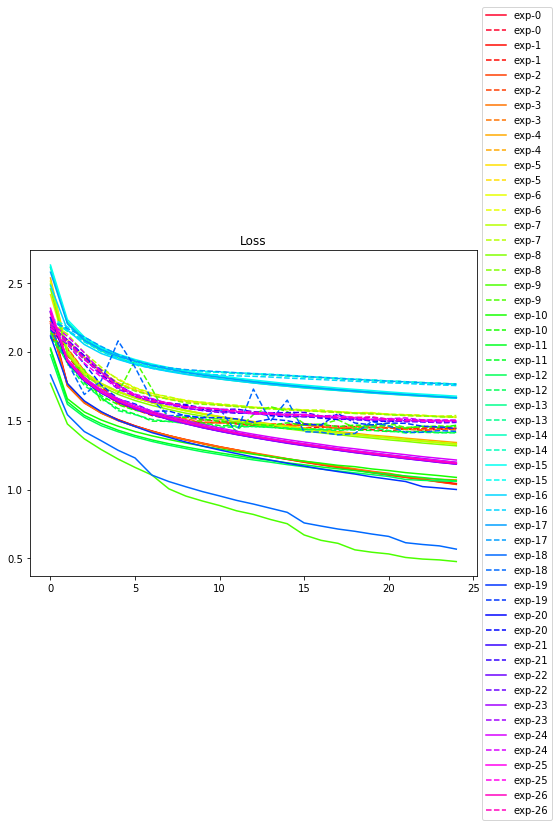

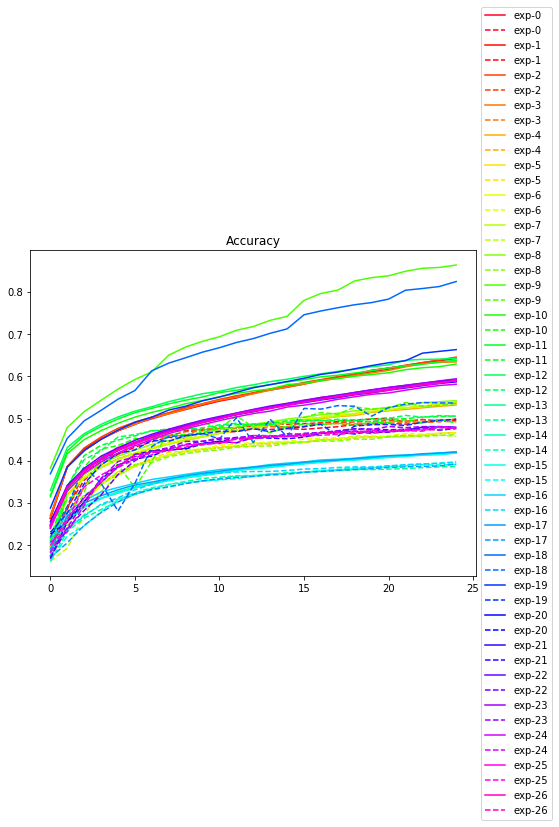

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()